# Read data and get beta values

First, import the necessary packages from pylluminator, and set the logger level to your convenience.

In [1]:
from pylluminator.annotations import Annotations, ArrayType, GenomeVersion
from pylluminator.samples import Samples, read_samples
from pylluminator.visualizations import betas_density, betas_dendrogram, betas_2D, nb_probes_per_chr_and_type_hist, methylation_distribution
from pylluminator.utils import set_logger, download_from_geo

# path to your data, or a folder where the downloaded data will be saved
data_path = '~/data/pylluminator-tutorial/' 

# set the verbosity level, can be DEBUG, INFO, WARNING, ERROR
set_logger('WARNING')

## Read .idat files

### Download test data

For the purpose of this tutorial, you can download data from 'GEO database <https://www.ncbi.nlm.nih.gov/geo/>', or skip this step if you want to use you own data. 

We downloaded 3 samples from healthy prostate cells (PrEC) and 3 samples from prostate cancer cell (LNCaP)

In [2]:
download_from_geo(['GSM7698438', 'GSM7698446', 'GSM7698462', 'GSM7698435', 'GSM7698443', 'GSM7698459'], data_path)

### Define and read annotation
First, define the array type of your data and the genome version in order to read the associated information files (manifest, masks, genome information...)

The first run of this code might take a while, as the script will download the manifest and genome info files.

In [3]:
# define those parameters to match your data
array_type = ArrayType.HUMAN_EPIC_V2  # run ArrayType? to see available types
genome_version = GenomeVersion.HG38  # run GenomeVersion? to see available genome versions

# read annotation
annos = Annotations(array_type, genome_version)

#-------------------------------------------------------------

# alternative: if you don't know what your data is, you can set annos to None and let the script detect the array version when reading samples
# annos = None

### Read samples .idat

Now set the paths to your data and to the sample sheet if you have one.

In [4]:
# minimum number of detected beads per probe
min_beads = 4

# if no sample sheet is provided, it will be rendered automatically. Use parameter sample_sheet_path or sample_sheet_name to specify one.
my_samples = read_samples(data_path, annotation=annos, min_beads=min_beads, keep_idat=True)  

# let's check the generated sample sheet !
my_samples.sample_sheet

sample_id  sample_name
0  GSM7698459   PREC_500_3
1  GSM7698462  LNCAP_500_3
2  GSM7698435   PREC_500_1
3  GSM7698443   PREC_500_2
4  GSM7698438  LNCAP_500_1
5  GSM7698446  LNCAP_500_2

Now is a good time to check if any sample sheet value has the wrong type. Having a category value encoded as a number can lead to unexpected results, so be sure to convert them to string if need (e.g. the sample ID or sentrix ID)

In [5]:
my_samples.sample_sheet.dtypes
# we're all good here, since sentrix_id and sentrix_position are unknown - but if needed here is an example of how to change a column type:
# my_samples = my_samples.astype({'sentrix_id': str})

sample_id      object
sample_name    object
dtype: object

Example of the signal dataframe for a sample

In [6]:
my_samples.get_signal_df()['PREC_500_3']

signal_channel                                G               R        
methylation_state                             M       U       M       U
type channel probe_type probe_id                                       
I    G       cg         cg00000769_BC11   171.0  5796.0   275.0  1561.0
                        cg00000957_TC11  3127.0   414.0   445.0   510.0
                        cg00001349_TC11  7365.0  2321.0  1526.0   280.0
                        cg00002033_TC11   205.0  3947.0   195.0   378.0
                        cg00002033_TC12   232.0  4576.0   217.0   711.0
...                                         ...     ...     ...     ...
II   nan     snp        rs877309_BC21     190.0     NaN     NaN  8029.0
                        rs9363764_BC21   2458.0     NaN     NaN  4125.0
                        rs966367_BC21    1264.0     NaN     NaN  2420.0
                        rs966367_BC22    1117.0     NaN     NaN  1991.0
                        rs9839873_BC21    879.0     NaN     NaN  1363.0

[937688 rows x 4 columns]

Let's add a custom column to our sample sheet

In [7]:
my_samples.sample_sheet['sample_type'] = [n.split('_')[0] for n in my_samples.sample_sheet.sample_name]
my_samples.sample_sheet

sample_id  sample_name sample_type
0  GSM7698459   PREC_500_3        PREC
1  GSM7698462  LNCAP_500_3       LNCAP
2  GSM7698435   PREC_500_1        PREC
3  GSM7698443   PREC_500_2        PREC
4  GSM7698438  LNCAP_500_1       LNCAP
5  GSM7698446  LNCAP_500_2       LNCAP

### Save pylluminator samples (optional)

As reading lots of samples can take a couple of minutes, you might want to save the Samples object to a file for later use. Here is how.

In [8]:
my_samples.save('raw_samples')

# For later use, here is how to load samples :
# my_samples = Samples.load('raw_samples')

## Calculate and plot beta values

Once your samples are loaded, you can already calculate and plot the beta values of the raw data :

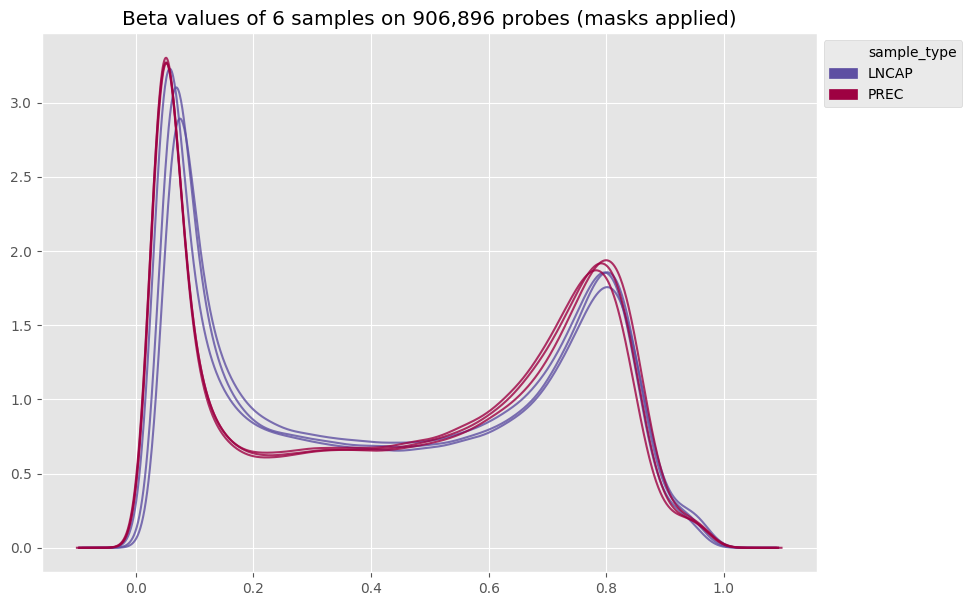

In [9]:
my_samples.calculate_betas(include_out_of_band=True)
betas_density(my_samples, color_column='sample_type')

## Preprocessing

Here is the classical preprocessing pipeline for human samples. 

Note that each step modifies the Samples object directly, so it's useful to save the raw samples first (see step 1.4) if you want to try different preprocessing methods.

In [10]:
my_samples.mask_quality_probes()
my_samples.infer_type1_channel()
my_samples.dye_bias_correction_nl()
my_samples.poobah()
my_samples.noob_background_correction()
my_samples.calculate_betas(include_out_of_band=True)

In [11]:
my_samples.save('preprocessed_samples')

Now let's see what the preprocessing changed in our beta values!

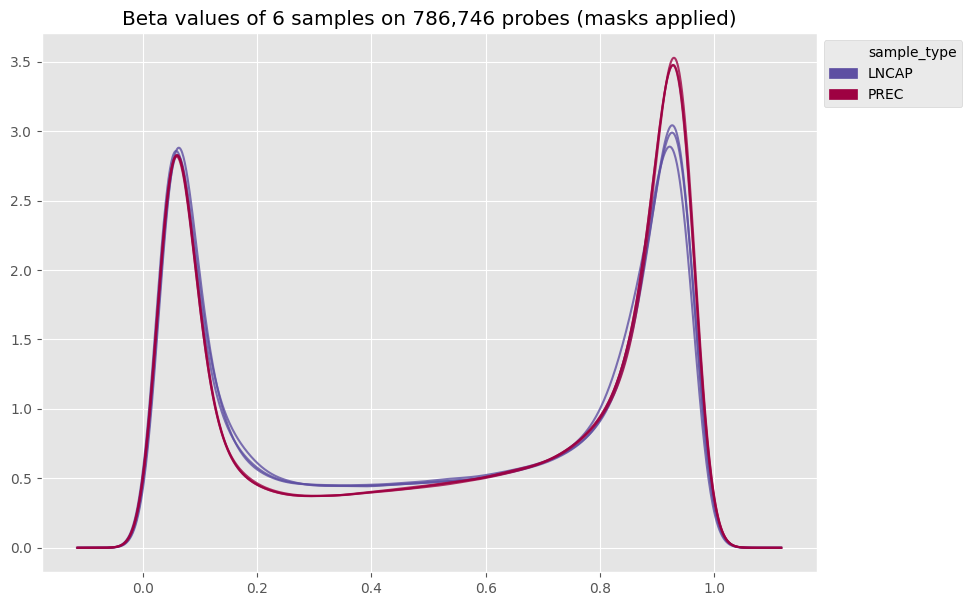

In [12]:
betas_density(my_samples, color_column='sample_type')

## Data insights

There are a few more plots you can already check to get to know your data:

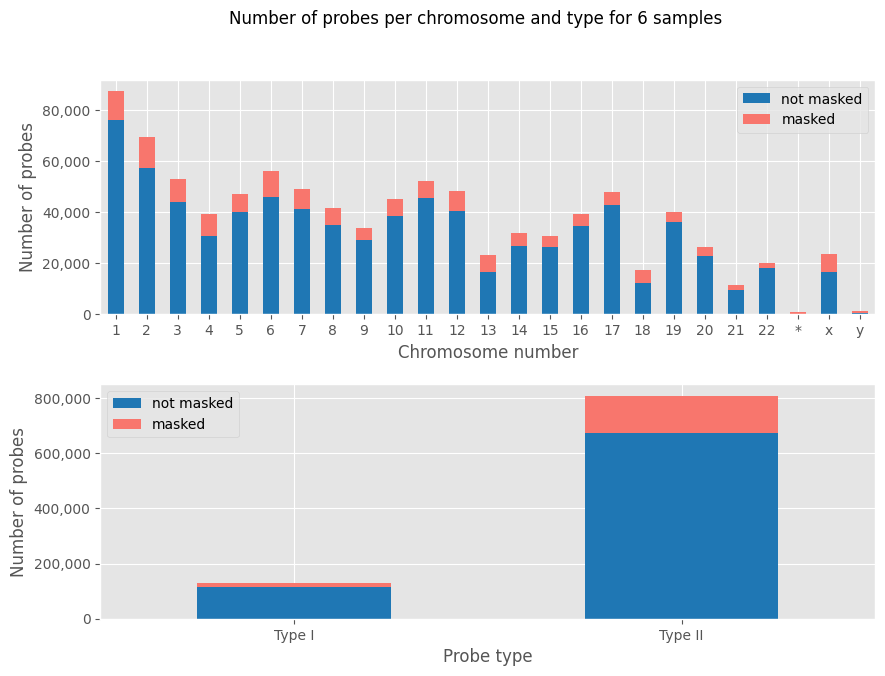

In [13]:
nb_probes_per_chr_and_type_hist(my_samples)

Using a principal component analysis (PCA), we can visualize the spatial distribution of the samples

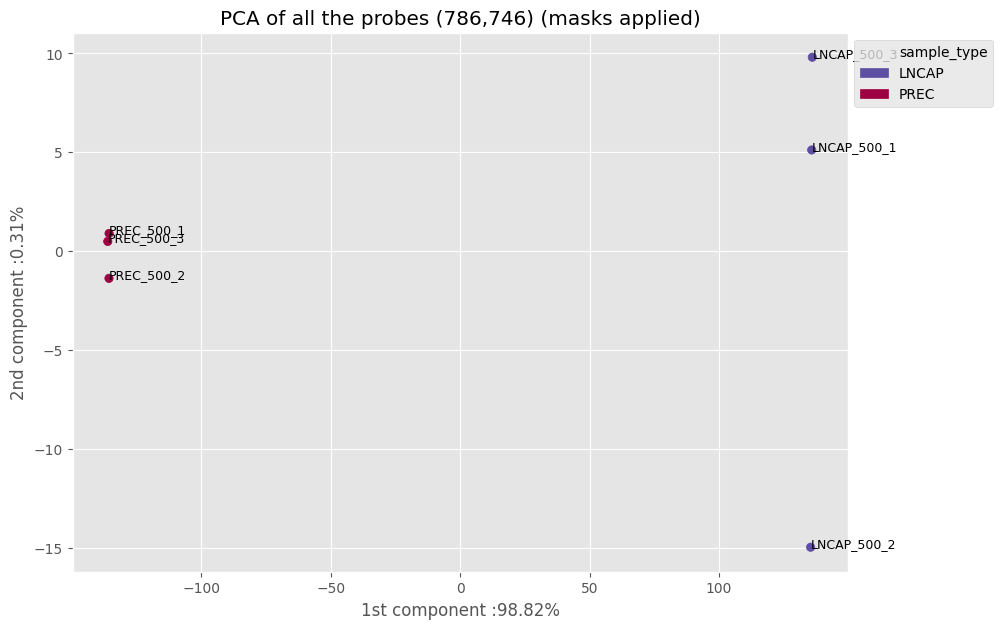

In [14]:
betas_2D(my_samples, model='PCA', color_column='sample_type')

The hierarchical clustering of the samples - nothing really surprising in the output :)

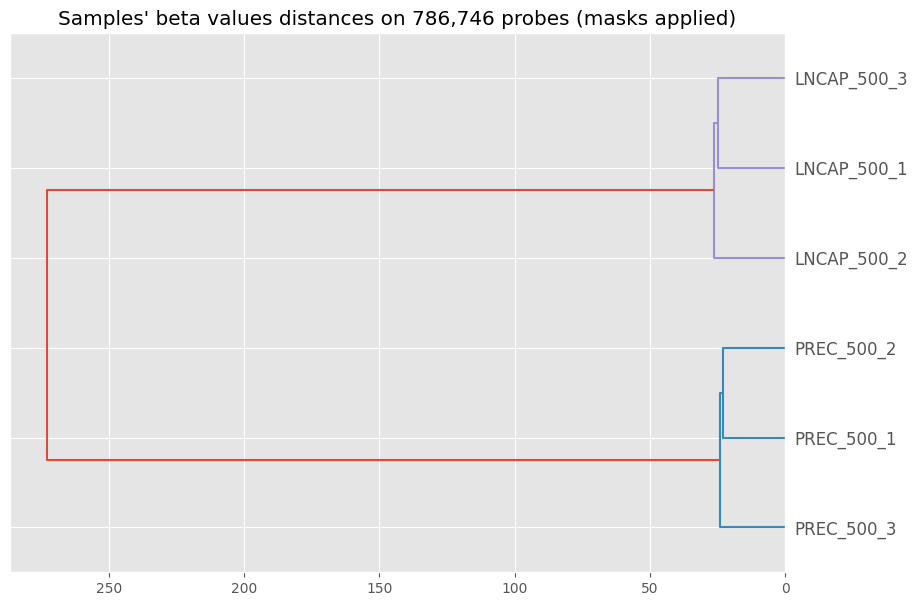

In [15]:
betas_dendrogram(my_samples)

And finally, check the distribution of hypo- and hyper- methylated probes, depending on the probes location

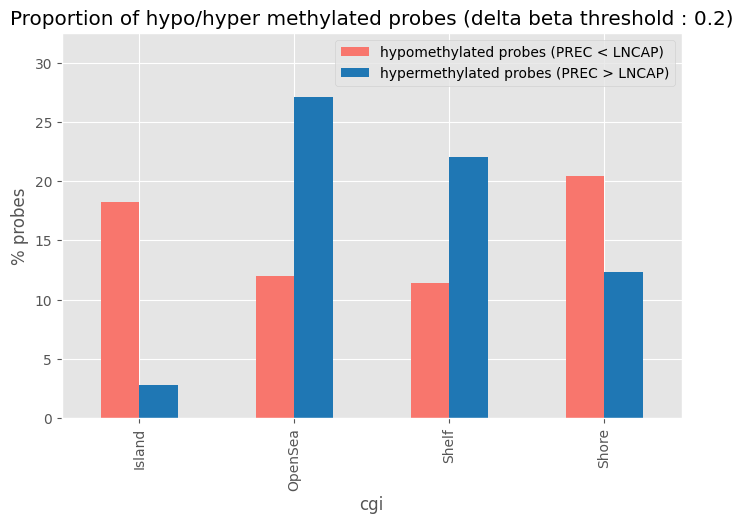

In [16]:
methylation_distribution(my_samples, group_column='sample_type', figsize=(8, 5))